<a href="https://colab.research.google.com/github/andrew-veriga/MathForML/blob/master/StridedCoffieCircles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load libs

In [1]:
import tensorflow as tf
import numpy as np

### Load picture

In [0]:
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # 1. Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)
# img_import = drive.CreateFile({'id':'1Nho1Ed_TnlSzTkJ0v0pc9dfvQH-HOws9'})
# img_import.GetContentFile('sample.png') 

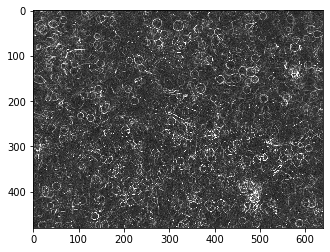

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path='https://github.com/andrew-veriga/MathForML/blob/master/CoffieCircles.png?raw=true'
#img_path='https://drive.google.com/file/d/1Nho1Ed_TnlSzTkJ0v0pc9dfvQH-HOws9/view?usp=sharing'
#img_path='https://www.dropbox.com/s/8naq7w6w2egpl6t/CoffieCircles.png?dl=0'
Image = mpimg.imread(img_path)
plt.imshow(Image)

In [4]:
print(Image.shape)

(480, 640, 4)


###Prepare picture
Convert Image to 2D

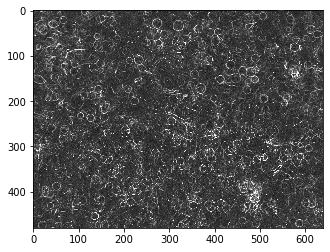

In [5]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

Image = rgb2gray(Image)    
plt.imshow(Image, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)

In [6]:
print (Image.shape)

(480, 640)


###Init variables

`MaxSize` - max size of square region

`MinSize` - min size of square region

`Contrast` - scalar set contrast of recognizing ring 
`Thick` - thickness of ring
`FoundCircles` - numpy array of centers and radiuces (3,None)

In [0]:
firstX=1
firstY=1
MaxSize = 24
MinSize = 10
Contrast = .18
Variance = 0.03
Thick = .8
FoundCircles = np.array([0,3])
_DEBUG_=False
ImageSize = Image.shape#(480//2,640//2)

In [0]:
# from scipy.spatial import distance
# for i in range(0,a.shape[0]):
#   d = [np.sum((a[i]-a[j])**2) for j in range(i+1,a.shape[0])] 
#   print(d) 

###function isCircleFound
calculate average brightness over all pixels of current square;
If pixels of SelectedRing have avg brightness more then avg brightness over all square - circle is found 


In [0]:
def isCircleFound(_box, _mask):
  
  brightness = (lambda arr: np.average(arr-np.min(_box)))#/(np.max(arr)-np.min(box))))
  if _DEBUG_:
    print (brightness(_box[_mask]))
    print (brightness(_box[~_mask]))
  if ((brightness(_box[_mask]) - brightness(_box[~_mask])) > Contrast and np.var(_box[_mask]) < Variance):
    print (brightness(_box[_mask]))
    print (brightness(_box[~_mask]))
    print(np.var(_box[_mask]))
    return True
  else:
    return False
  

In [0]:
#from scipy.special import softmax

def vecCircleFound(_box, _mask):
  brightness = (lambda arr, msk: np.mean((arr-np.min(arr,axis=(2,3), keepdims=True))[:,:,msk],axis=2))
  
  return np.logical_and(
      np.greater(brightness(_box,_mask) - brightness(_box,~_mask),Contrast),
      np.less(np.var(_box[:,:,_mask],axis=2), Variance)
      )
  

###function getMask
create square matrix of boolean as a ring of Trues inscribed in a square of Falses 

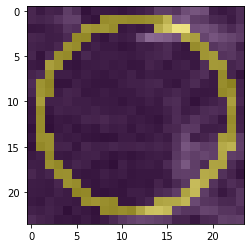

In [15]:
import itertools

def getMask( size, thick = 1 ):
    radius = (size-3)/2 
    center = np.array([(size-1)/2,(size-1)/2])
    vectors = [[(i,j) for j in range(size)] for i in range(size)]
    l = itertools.chain.from_iterable(zip(*vectors))
    
    # list of pairs (x,y) belong of ring
    selectedVecs = np.array(list(filter(lambda v: np.abs(np.linalg.norm(v - center) - radius) < thick,l)))
    
    #ring mask
    ring = np.array(np.zeros((size,size),dtype=np.bool))
    for (i,j) in (selectedVecs):
      ring[i,j]=True
    
    return ring

Mask = getMask( MaxSize, .8 )
square = Image[firstY:firstY+MaxSize, firstX:firstX+MaxSize]
    
#ring visualisation
fig, ax = plt.subplots()
ax.imshow(square, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
ax.imshow(getMask( MaxSize, .8 ),alpha=.5)
fig.show()
#print (isCircleFound(square, Mask))

##An example of founded ring

0.4003059997673639
0.1424489946521149
0.4003059997673639
0.1424489946521149
0.015598000734567005
True
0.015598000734567005


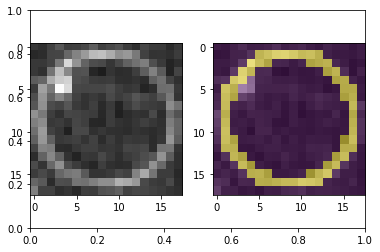

In [17]:
size, (x,y)= 18, (58, 13)

Mask = getMask( size, Thick )
square = Image[y:y+size, x:x+size]
    
#ring visualisation
fig, ax = plt.subplots()
ax = fig.add_subplot(1,2,1)
ax.imshow(square, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)

ax1=fig.add_subplot(1,2,2)
ax1.imshow(square, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
ax1.imshow(Mask,alpha=.5)
fig.show()
_DEBUG_=True
print(isCircleFound(square, Mask))
print(np.var(square[Mask]))
_DEBUG_=False

### function strides
split image to array of squares of given size strided by one pixel vertically and horisontally


In [0]:
#https://stackoverflow.com/questions/43086557/convolve2d-just-by-using-numpy

def strides(_image, _gridshape):
  padded_im = np.random.random(size=(np.add(_image.shape, _gridshape) - 1))
  padded_im[_gridshape[0]//2:_gridshape[0]//2+_image.shape[0],_gridshape[1]//2:_gridshape[1]//2 +_image.shape[1]] = _image
  # view_shape = tuple(np.subtract(_image.shape, _gridshape) + 1) + _gridshape
  view_shape = _image.shape + _gridshape
  strides = padded_im.strides + padded_im.strides
  # print(view_shape)
  return np.lib.stride_tricks.as_strided(padded_im,view_shape,strides,writeable=False)

##Main loop

In [0]:
MinSize, MaxSize = (10,24)
image_area=Image[:ImageSize[0],:ImageSize[1]]

res = [vecCircleFound(strides(image_area,(size,size)), getMask( size, Thick )) for size in range(MinSize,MaxSize+1)]
FoundCircles = np.dstack(res)

In [123]:
FoundCircles.shape


(481, 641, 19)

In [0]:
from tempfile import TemporaryFile

# outfile = TemporaryFile()
np.save('foundCircles', FoundCircles)

###Visualisation

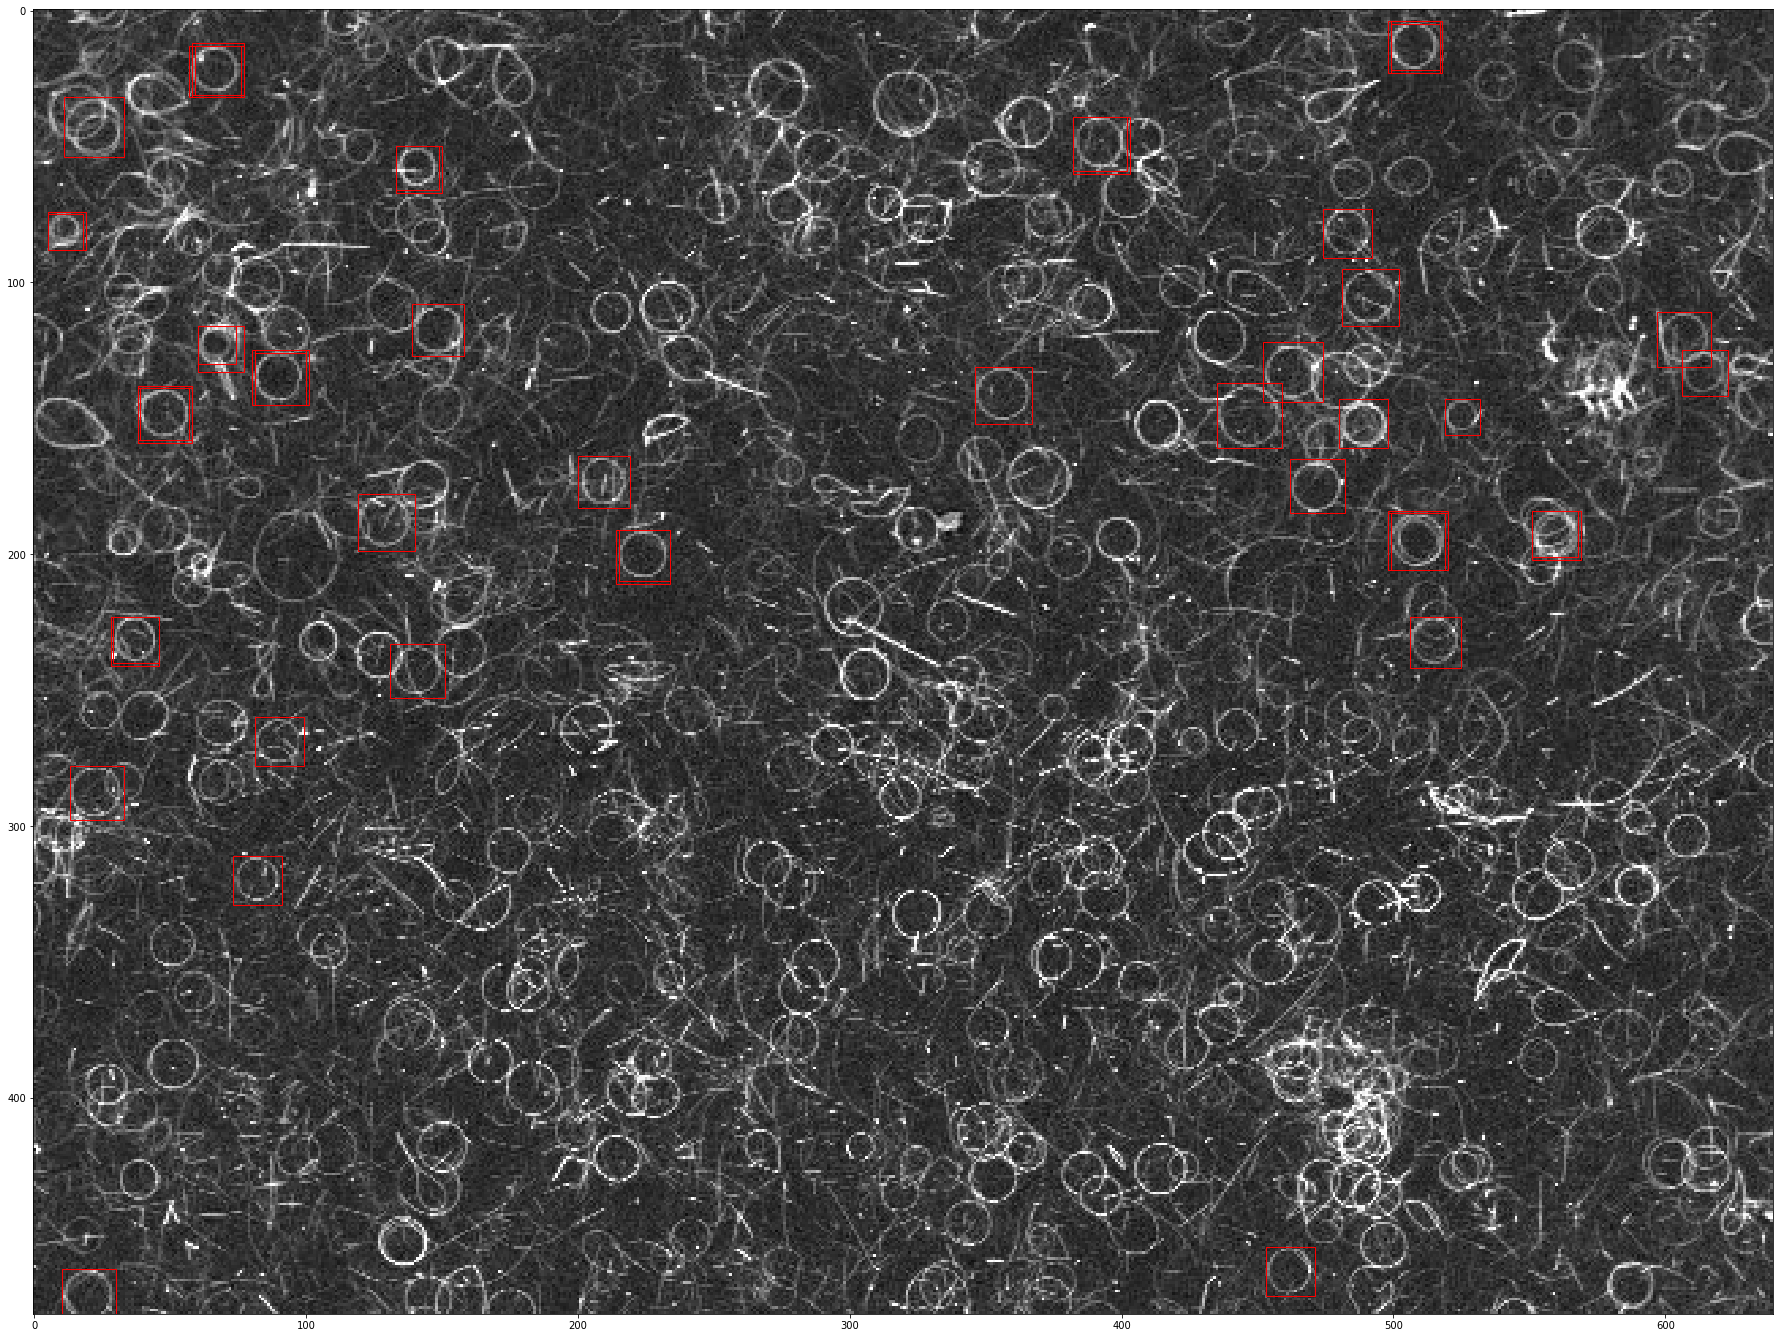

In [24]:
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(32, 24))
ax.imshow(Image,cmap=plt.get_cmap('gray') )
# Create a Rectangle patch

for y in range(FoundCircles.shape[0]):
  for x in range(FoundCircles.shape[1]):
    for s in range(MinSize,MaxSize+1):
      if (FoundCircles[y,x, s-MinSize]):
        rect = patches.Rectangle((x-s//2,y-s//2),s,s,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
plt.show(fig)

In [21]:
#[(30, 101), 40]
y=101
x=30
size = 40
square = Image[y:y+size, x:x+size]
mask = getMask( size, Thick )
arr = square[mask]
box = square
st = (lambda arr: np.mean((arr-np.min(arr))))
print (st(box[mask]))
print (st(box[~mask]))
print(np.var(box[mask]))


0.28207442110222863
0.1983998725808608
0.05047860578110671


In [146]:
FoundCircles[479]

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [

False


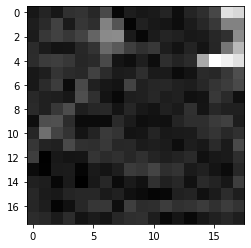

In [147]:
size = 18
sub_matrices = strides(image_area,(size,size))
plt.imshow(sub_matrices[479,639],cmap=plt.get_cmap('gray'))

print (isCircleFound(sub_matrices[479,0],getMask(size,Thick)))